# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)


## CC1, Q4

In [6]:
def cc1_q4_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    sigma_RN: np.ndarray | None,
    omega_RN_R: np.ndarray | None,
    omega_dot_RN_R: np.ndarray | None,
    I: np.ndarray,
    K: float,
    P: float,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Q4 control torque u_B in the body frame, compatible with simulate_CC.

    This is written in the same "tracking-form" structure as later controllers,
    but Q4 is typically used as a regulator:
        sigma_RN = 0, omega_RN_R = 0, omega_dot_RN_R = 0

    Key point:
        We avoid MRP <-> DCM conversions entirely.
        sigma_BR is computed using direct MRP subtraction:
            sigma_BR = sigma_BN (-) sigma_RN

    Inputs:
        t: time [s] (unused here, kept for signature compatibility)
        sigma_BN: body MRPs relative to inertial N
        omega_BN_B: body angular rate expressed in B [rad/s]
        sigma_RN: reference MRPs relative to N (optional; default zero)
        omega_RN_R: reference angular rate expressed in R (optional; default zero)
        omega_dot_RN_R: reference angular accel expressed in R (optional; default zero)
        I: inertia matrix expressed in B
        K: attitude gain
        P: rate gain
        L_B: disturbance torque expressed in B (default zero)

    Output:
        u_B: (3,) control torque expressed in B
    """
    if sigma_RN is None:
        sigma_RN = np.zeros(3)
    if omega_RN_R is None:
        omega_RN_R = np.zeros(3)
    if omega_dot_RN_R is None:
        omega_dot_RN_R = np.zeros(3)
    if L_B is None:
        L_B = np.zeros(3)

    # -------------------------
    # 1) Attitude error: sigma_BR
    # -------------------------
    # Direct MRP subtraction (no DCMs):
    #   sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # -------------------------
    # 2) Rate error: omega_BR_B
    # -------------------------
    # In Q4 regulator usage, omega_RN_* is zero, so omega_BR_B reduces to omega_BN_B.
    # We keep the tracking-form structure anyway.
    #
    # Note: This assumes omega_RN_R is already provided in a compatible way.
    # For Q4 regulator: omega_RN_R = 0, so no frame mapping is needed.
    omega_BR_B = omega_BN_B - omega_RN_R

    # -------------------------
    # 3) Control law (Q4 form)
    # -------------------------
    # For Q4 regulator, feedforward terms are zero, but the base rigid-body
    # gyro term omega x (I omega) remains part of the dynamics, so the control
    # torque includes the + omega x (I omega) compensation term.
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )

    return u_B


In [7]:
def q4_lyapunov_V(
    sigma_BN: np.ndarray,
    omega_BN: np.ndarray,
    I: np.ndarray,
    K: float,
) -> float:
    """
    Evaluate the Lyapunov candidate for the Q4 MRP attitude controller.

    Computes:
        V = 1/2 * omega_BN^T * I * omega_BN
            + 2K * ln(1 + sigma_BN^T * sigma_BN)

    Parameters
    ----------
    sigma_BN : np.ndarray
        Body attitude relative to inertial frame, expressed as MRPs (3,).
    omega_BN : np.ndarray
        Body angular velocity relative to inertial frame (rad/s, 3,).
    I : np.ndarray
        Spacecraft inertia matrix expressed in the body frame (3×3).
    K : float
        Attitude proportional gain.

    Returns
    -------
    V : float
        Scalar Lyapunov function value.
    """
    V = 0.5 * omega_BN @ (I @ omega_BN) + 2.0 * K * np.log(1.0 + sigma_BN @ sigma_BN)
    return V

In [8]:
def cc_xdot(
    t: float,
    x: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    sigma_RN: np.ndarray,
    omega_RN_R: np.ndarray,
    omega_dot_RN_R: np.ndarray,
    controller,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Closed-loop state derivative for concept checks (MRP attitude + body rates).

    State:
        x = [sigma_BN (3), omega_BN_B (3)]

    Note:
        Reference inputs are assumed constant over RK4 substeps (zero-order hold).

    Inputs:
        controller: callable implementing u_B = controller(...)
        L_B: optional disturbance torque expressed in B

    Output:
        x_dot: (6,) state derivative
    """
    sigma_BN = x[0:3]
    omega_BN_B = x[3:6]

    if L_B is None:
        L_B = np.zeros(3)

    u_B = controller(
        t=t,
        sigma_BN=sigma_BN,
        omega_BN_B=omega_BN_B,
        sigma_RN=sigma_RN,
        omega_RN_R=omega_RN_R,
        omega_dot_RN_R=omega_dot_RN_R,
        I=I,
        K=K,
        P=P,
        L_B=L_B,
    )

    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)

    xdot = np.hstack((sigma_dot, omega_dot_B))

    return xdot

In [9]:
def simulate_CC(
    controller=cc1_q4_controller_u,
    I: np.ndarray | None = None,
    K: float = 5.0,
    P: float = 10.0,
    f: float = 0.05,
    sigma0: np.ndarray | None = None,
    omega0_deg: np.ndarray | None = None,
    t0: float = 0.0,
    tf: float = 120.0,
    dt: float = 0.01,
    L_B: np.ndarray | None = None,
    report_time_s: float = 40.0,
    ref_mode: str = "tracking",          # "tracking" (Q5) or "regulator" (Q4)
    report_quantity: str = "sigma_BR",   # "sigma_BR" or "sigma_BN"
) -> dict[str, np.ndarray | dict[str, float | np.ndarray]]:
    """
    Generic RK4 simulator for attitude concept checks (MRP attitude + body rates).

    Inputs:
        controller: callable u_B = controller(t, sigma_BN, omega_BN_B, sigma_RN, omega_RN_R, omega_dot_RN_R, I, K, P, L_B)
        I: (3,3) inertia matrix in body frame B (default diag([100, 75, 80]))
        K, P: scalar attitude and rate gains
        f: reference frequency for tracking mode (only used if ref_mode="tracking")
        sigma0: (3,) initial MRPs sigma_BN
        omega0_deg: (3,) initial body rates in deg/s (converted internally to rad/s)
        t0, tf, dt: simulation start, end, and step [s]
        L_B: (3,) constant external torque applied in plant dynamics (optional)
        report_time_s: time at which to print a norm (closest grid point)
        ref_mode: "tracking" uses built-in sinusoidal reference; "regulator" uses zero reference
        report_quantity: "sigma_BR" prints ||sigma_B/R||, "sigma_BN" prints ||sigma_B/N||

    Outputs:
        results: dict with keys:
            t: (N,) time history [s]
            x: (N,6) state history [sigma_BN, omega_BN_B]
            u: (N,3) control torque history [N*m]
            V: (N,) Lyapunov metric history
            sigma_norm: (N,) norm history (either ||sigma_BR|| or ||sigma_BN|| depending on report_quantity)
            sigma_BR: (N,3) attitude error history (MRPs)
            omega_BR: (N,3) rate error history in body frame B
            params: dict of run settings
    """
    if I is None:
        I = np.diag([100.0, 75.0, 80.0])

    if sigma0 is None:
        sigma0 = np.array([0.1, 0.2, -0.1], dtype=float)
    else:
        sigma0 = np.array(sigma0, dtype=float)

    if omega0_deg is None:
        omega0_deg = np.array([30.0, 10.0, -20.0], dtype=float)
    else:
        omega0_deg = np.array(omega0_deg, dtype=float)

    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # --- Reference signals ---
    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode.lower() == "tracking":
        for k, t in enumerate(t_hist):
            st = np.sin(f * t)
            ct = np.cos(f * t)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st], dtype=float)
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct], dtype=float)

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * (ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot)

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0, edge_order=2)

    elif ref_mode.lower() == "regulator":
        # leave arrays as zeros
        pass
    else:
        raise ValueError("ref_mode must be 'tracking' or 'regulator'")

    # --- Storage ---
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)  # norm of sigma_BR (for tracking) or sigma_BN (if you choose)

    x_hist[0] = x

    # --- Simulation loop ---
    for k in range(N - 1):
        t = t_hist[k]
        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_RN = sigma_RN_hist[k]
        omega_RN_R = omega_RN_R_hist[k]
        omega_dot_RN_R = omega_dot_RN_R_hist[k]

        # --- Errors for logging ---
        C_BN = ak.MRP_to_DCM(sigma_BN)
        C_RN = ak.MRP_to_DCM(sigma_RN)
        C_BR = C_BN @ C_RN.T

        sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

        omega_RN_B = C_BR @ omega_RN_R
        omega_BR_B = omega_BN_B - omega_RN_B

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B

        # choose what "sigma_norm_hist" means
        if report_quantity == "sigma_BN":
            sigma_norm_hist[k] = np.linalg.norm(sigma_BN)
        else:
            sigma_norm_hist[k] = np.linalg.norm(sigma_BR)

        # --- Control for logging ---
        u_B = controller(
            t=t,
            sigma_BN=sigma_BN,
            omega_BN_B=omega_BN_B,
            sigma_RN=sigma_RN,
            omega_RN_R=omega_RN_R,
            omega_dot_RN_R=omega_dot_RN_R,
            I=I,
            K=K,
            P=P,
            L_B=L_B,
        )
        u_hist[k] = u_B

        # --- Lyapunov (kept same form; for regulator it is still a valid metric) ---
        V_hist[k] = 0.5 * (omega_BR_B @ (I @ omega_BR_B)) + 2.0 * K * np.log(1.0 + sigma_BR @ sigma_BR)

        # --- Integrate (RK4) ---
        x = rk4_step(
            cc_xdot,
            t,
            x,
            dt,
            I,
            K,
            P,
            sigma_RN,
            omega_RN_R,
            omega_dot_RN_R,
            controller,
            L_B,
        )
        x[0:3] = mrp_shadow(x[0:3])
        x_hist[k + 1] = x

    # --- Final sample ---
    sigma_BN = x_hist[-1, 0:3]
    omega_BN_B = x_hist[-1, 3:6]
    sigma_RN = sigma_RN_hist[-1]
    omega_RN_R = omega_RN_R_hist[-1]
    omega_dot_RN_R = omega_dot_RN_R_hist[-1]

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    sigma_BR_hist[-1] = sigma_BR
    omega_BR_hist[-1] = omega_BR_B

    if report_quantity == "sigma_BN":
        sigma_norm_hist[-1] = np.linalg.norm(sigma_BN)
    else:
        sigma_norm_hist[-1] = np.linalg.norm(sigma_BR)

    u_hist[-1] = controller(
        t=t_hist[-1],
        sigma_BN=sigma_BN,
        omega_BN_B=omega_BN_B,
        sigma_RN=sigma_RN,
        omega_RN_R=omega_RN_R,
        omega_dot_RN_R=omega_dot_RN_R,
        I=I,
        K=K,
        P=P,
        L_B=L_B,
    )

    V_hist[-1] = 0.5 * (omega_BR_B @ (I @ omega_BR_B)) + 2.0 * K * np.log(
        1.0 + sigma_BR @ sigma_BR
    )

    # --- Report ---
    idx_report = int(np.argmin(np.abs(t_hist - report_time_s)))
    t_report = float(t_hist[idx_report])

    if report_quantity == "sigma_BN":
        print(f"CC: ||sigma_B/N|| at t={t_report:.3f} s = {sigma_norm_hist[idx_report]:.15f}")
    else:
        print(f"CC: ||sigma_B/R|| at t={t_report:.3f} s = {sigma_norm_hist[idx_report]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "u": u_hist,
        "V": V_hist,
        "sigma_norm": sigma_norm_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR": omega_BR_hist,
        "params": {
            "I": I,
            "K": K,
            "P": P,
            "f": f,
            "dt": dt,
            "t0": t0,
            "tf": tf,
            "L_B": L_B,
            "ref_mode": ref_mode,
            "report_time_s": report_time_s,
            "report_quantity": report_quantity,
        },
    }
    return results




In [10]:
q4_sim_result = simulate_CC(controller=cc1_q4_controller_u, ref_mode='regulator', report_quantity="sigma_BN", report_time_s=30.0)
q4_sim_result

CC: ||sigma_B/N|| at t=30.000 s = 0.194751484380332


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01,
          5.23025206e-01,  1.74166977e-01, -3.48566918e-01],
        [ 1.02058633e-01,  2.00886941e-01, -1.02634236e-01,
          5.22451696e-01,  1.73801221e-01, -3.48067787e-01],
        ...,
        [-1.01918765e-03,  3.57166023e-05,  5.41518866e-04,
         -3.76251395e-04,  4.65355768e-05, -8.66779721e-05],
        [-1.02012731e-03,  3.58313740e-05,  5.41301715e-04,
         -3.75365758e-04,  4.64497372e-05, -8.69078624e-05],
        [-1.02106476e-03,  3.59459324e-05,  5.41083990e-04,
         -3.74480537e-04,  4.63639357e-05, -8.71373296e-05]]),
 'u': array([[-6.04060518e+00, -6.40073829e+00,  1.70602786e+00],
        [-6.03894394e+00, -6.39007678e+00,  1.71491330e+00],
        [-6.03728315e+00, -

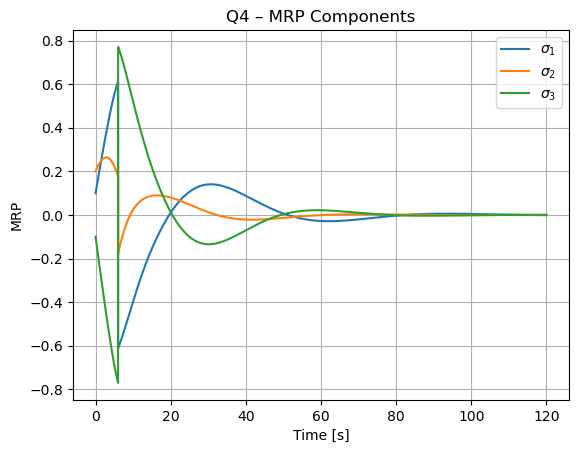

In [11]:
t = q4_sim_result['t']
x = q4_sim_result['x']
u = q4_sim_result['u']
V = q4_sim_result['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

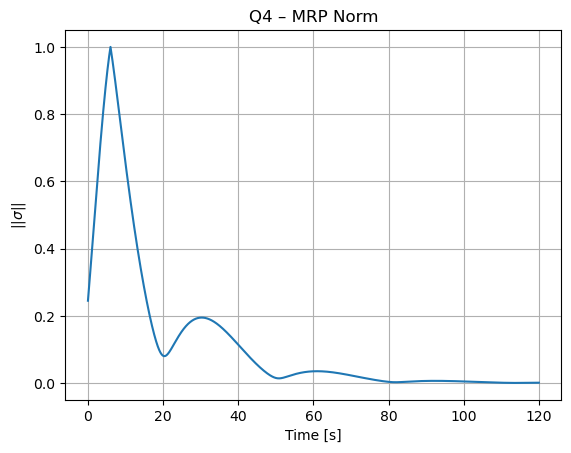

In [12]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


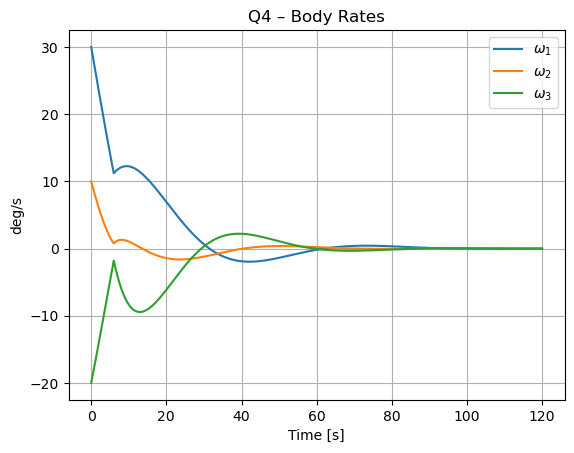

In [13]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

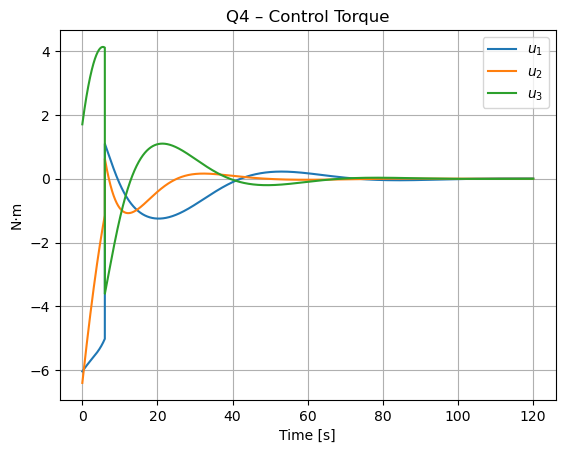

In [14]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


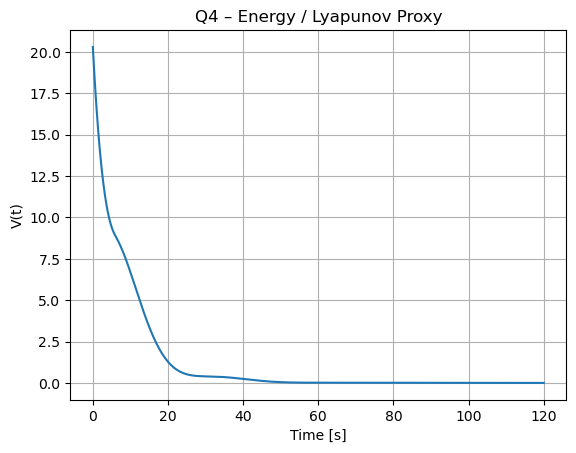

In [15]:
plt.figure()
plt.plot(t, V)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("V(t)")
plt.title("Q4 – Energy / Lyapunov Proxy")
plt.show()


## CC1, Q5

In [16]:
def cc1_q5_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    sigma_RN: np.ndarray,
    omega_RN_R: np.ndarray,
    omega_dot_RN_R: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Attitude tracking control torque u_B for the concept check tracking law.

    Inputs:
        t: time [s]
        sigma_BN: body MRPs relative to inertial N
        omega_BN_B: body angular rate expressed in B [rad/s]
        sigma_RN: reference MRPs relative to inertial N
        omega_RN_R: reference angular rate expressed in R [rad/s]
        omega_dot_RN_R: reference angular acceleration expressed in R [rad/s^2]
        I: inertia matrix expressed in B
        K: attitude gain
        P: rate gain
        L_B: disturbance torque expressed in B (default zero)

    Output:
        u_B: control torque expressed in B
    """
    if L_B is None:
        L_B = np.zeros(3)

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + ak.skew_symmetric(omega_BN_B) @ I @ omega_BN_B
        - L_B
    )
    return u_B

In [17]:
q5_sim_result = simulate_CC(controller=cc1_q5_controller_u, ref_mode='tracking', report_quantity="sigma_BR", report_time_s=40.0)
q5_sim_result

CC: ||sigma_B/R|| at t=40.000 s = 0.158824441221161


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850359],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'u': array([[-4.50074568, -5.59384176,  2.21271521],
        [-4.50310823, -5.57669134,  2.21993479],
        [-4.50551689, -5.5595468 ,  2.22707249],
        ...,
        [ 0.04026097, -0.18178618, -0.06871974],
        [ 0.04017335, -0.18182018, -0.06860042],
        [ 0.04008574, -0.18185413, 

In [18]:
t = q5_sim_result["t"]
x = q5_sim_result["x"]
sigma_BR = q5_sim_result["sigma_BR"]
omega_BR = q5_sim_result["omega_BR"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

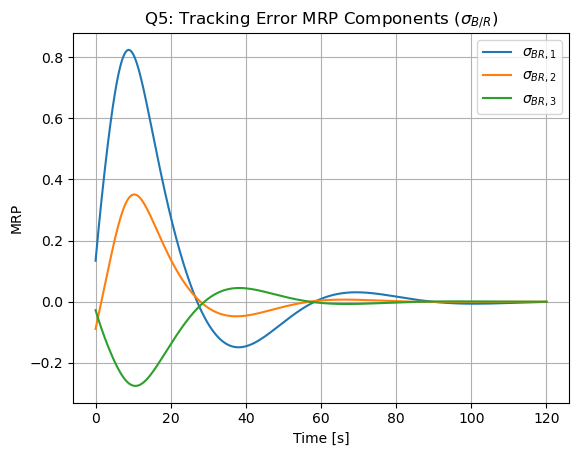

In [19]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


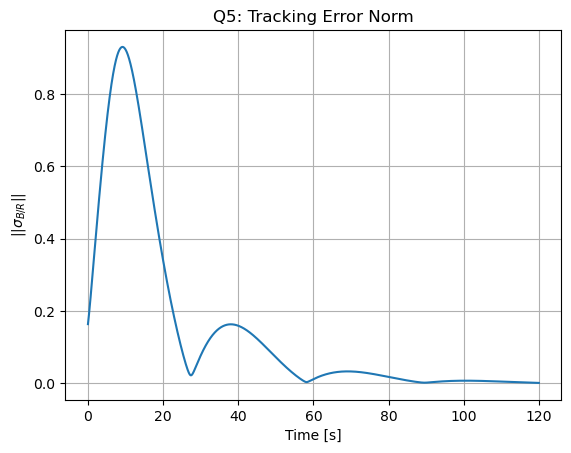

In [20]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


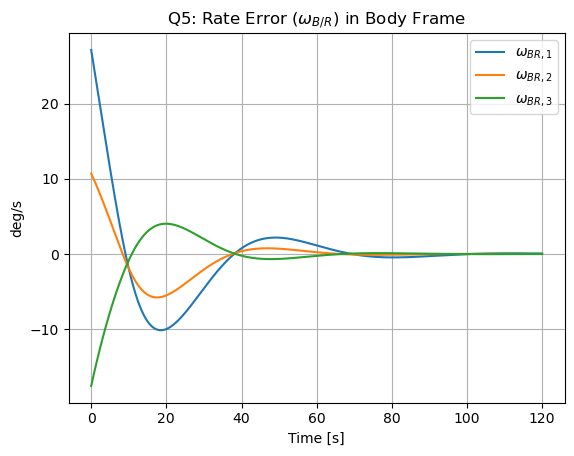

In [21]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


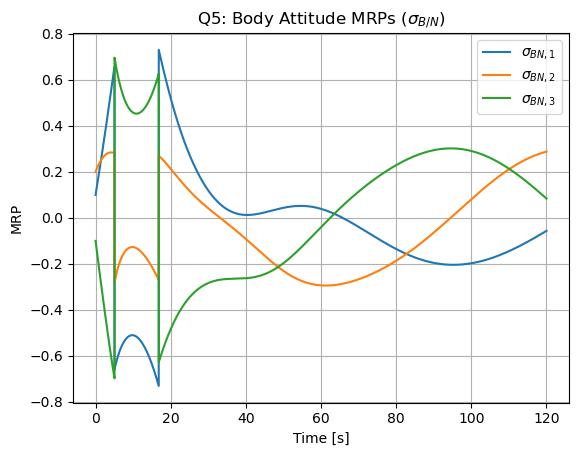

In [22]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


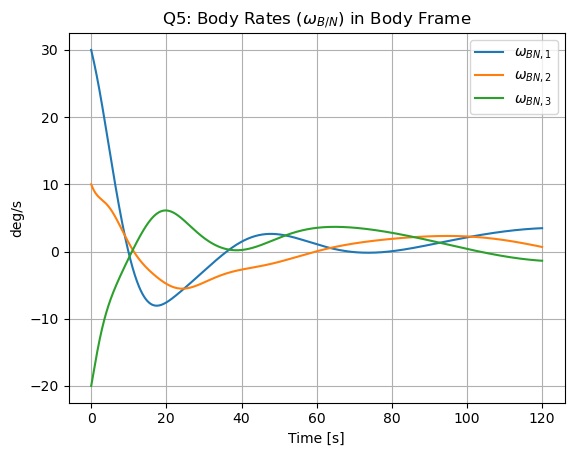

In [23]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


## CC2, Q5

In [24]:
def cc2_q5_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    sigma_RN: np.ndarray,
    omega_RN_R: np.ndarray,
    omega_dot_RN_R: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Concept Check #5 controller:
        u = -K*sigma_BR - P*omega_BR
    """
    # Attitude error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Rate error
    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = -K * sigma_BR - P * omega_BR_B
    return u_B


In [25]:
cc2q5_sim_results = simulate_CC(
    controller=cc2_q5_controller_u,
    ref_mode="tracking",
    report_quantity="sigma_BR",
    report_time_s=20.0,
    L_B=None,
)


CC: ||sigma_B/R|| at t=20.000 s = 0.377862387698462


## CC2, Q6

In [26]:
def cc2_q6_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    sigma_RN: np.ndarray,
    omega_RN_R: np.ndarray,
    omega_dot_RN_R: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Concept Check #6 controller:
        u = -K*sigma_BR - P*omega_BR
            + I*(omega_dot_RN_B - omega_BN_B x omega_RN_B)
            + [omega_BN_B]_x * I * omega_BN_B

    Note: does NOT include '- L_B' term inside u (that is CC #7).
    External torque L_B is modeled in the plant via simulate_CC / dynamics.
    """
    # Attitude error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into B
    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + ak.skew_symmetric(omega_BN_B) @ (I @ omega_BN_B)
    )
    return u_B

In [27]:
L = np.array([0.5, -0.3, 0.2], dtype=float)

cc2q6_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    ref_mode="tracking",
    report_quantity="sigma_BR",
    report_time_s=80.0,
    L_B=L,
)
cc2q6_sim_results

CC: ||sigma_B/R|| at t=80.000 s = 0.134442565470039


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102984,  0.20044428, -0.10131741,  0.52322891,  0.17423502,
         -0.34847861],
        [ 0.10205986,  0.20088702, -0.10263419,  0.52285864,  0.17393824,
         -0.34789116],
        ...,
        [ 0.06768015,  0.24358509,  0.06565066,  0.05365285, -0.0110419 ,
         -0.03860909],
        [ 0.0677612 ,  0.24358807,  0.06549111,  0.05365173, -0.01106381,
         -0.03860704],
        [ 0.06784224,  0.24359098,  0.06533156,  0.05365059, -0.01108571,
         -0.03860497]]),
 'u': array([[-4.50074568, -5.59384176,  2.21271521],
        [-4.50371658, -5.57662938,  2.21988347],
        [-4.50673151, -5.55942187,  2.22697078],
        ...,
        [-0.50876535,  0.09414201, -0.16892653],
        [-0.50881475,  0.09417934, -0.16878899],
        [-0.50886414,  0.09421671, 

## CC2, Q7

In [28]:
def cc2_q7_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    sigma_RN: np.ndarray,
    omega_RN_R: np.ndarray,
    omega_dot_RN_R: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    L_B: np.ndarray | None = None,
) -> np.ndarray:
    """
    Concept Check #7 controller:
        u = -K*sigma_BR - P*omega_BR
            + I*(omega_dot_RN_B - omega_BN_B x omega_RN_B)
            + [omega_BN_B]_x * I * omega_BN_B
            - L_B
    """
    if L_B is None:
        L_B = np.zeros(3)

    # Attitude error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into B
    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + ak.skew_symmetric(omega_BN_B) @ (I @ omega_BN_B)
        - L_B
    )
    return u_B

In [29]:
L = np.array([0.5, -0.3, 0.2], dtype=float)

cc2q7_sim_results = simulate_CC(
    controller=cc2_q7_controller_u,
    ref_mode="tracking",
    report_quantity="sigma_BR",
    report_time_s=70.0,
    L_B=L,
)
cc2q7_sim_results

CC: ||sigma_B/R|| at t=70.000 s = 0.032210380467990


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850359],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'u': array([[-5.00074568, -5.29384176,  2.01271521],
        [-5.00310823, -5.27669134,  2.01993479],
        [-5.00551689, -5.2595468 ,  2.02707249],
        ...,
        [-0.45973903,  0.11821382, -0.26871974],
        [-0.45982665,  0.11817982, -0.26860042],
        [-0.45991426,  0.11814587, 